In [1]:
import sys
import os
# Get the directory path of the current script
current_script_directory = os.path.dirname(os.path.abspath(__file__))
# Construct the path to the src directory
src_directory = os.path.join(current_script_directory, "..", "src")
srcpro_directory = os.path.join(current_script_directory, "..", "src/propythia")

# Add the src directory to sys.path
sys.path.append(src_directory)
sys.path.append(srcpro_directory)

# Quickstart building and using Word Embeddings with Propythia and application to ML and DL models

This notebook intends to go over the building and application of Word embedding vectors to describe biological sequences and their use with ML and DL. The notebook uses protein sequences but the same principle may be used for DNA sequences. 

The Python module Bumblebee was developed for processing biological sequences aiming to search for semantic
meaning in sequence ”words” (such as nucleotides and amino
acids). This module was then integrated in ProPythia. It is organized in sub-modules so that
the user can use them in different specific tasks and adapt
them to fit the problem that is working on. The user can set
specific values for the majority of the parameters, but default
values are established. 


This include: 

    1) Read sequence sub-module: To read and/or change sequences. This is especially important to replace nonrelevant/not-common AAs simplifying the vocabulary.
    
    2) Sequence processing sub-module: To generate subsequences; Implements the segmentation of sequences by grams of size n and overlapping (or not) method.
    
    3) Create vocabulary list sub-module: To get all the vocabulary in the dataset, necessary to train the WE.
    It allows to fetch a list of n-grams from pre-existing JSON file or create the list if it is not present.
    
    4) Training word embedding models sub-module: To train and save WE models; It is possible to train W2V
    and FastText models with both CBOW or SG algorithms (based on gensim library). 
    
    5) Load models list sub-module: To load a pre-trained embedding model;
    
    6) Protein Vector representation sub-module: To get a vector representation of a sequence or the matrix of
    vectors accordingly to a model. It obtains a vector for a given n-gram and the number of occurrences of that
    n-gram. Three methods of representing sequences as vectors are implemented as described above.
    
    7) Interpretability sub-module: To visualize WE in space and get similarities between vectors. It uses t-SNE to
    create plots related to physicochemical properties of individual AA, including charge, volume, mass, Van der Waals Volume, polarity and hydrophobicity. For ngrams larger than 1, mean values of these properties are presented as described for Asgari et al. The sub-module also includes binding free energy values for trigrams, based on experimental data. If needed, users can define additional characteristics. Additionally, the models can also retrieve scores of similarity and neighborhood of the n-grams to aid in understanding vector similarities.


Important decisions to take are: 

    Either use a pretrained WE model or train your own model. 
    
    Choose the size of the biological 'words' and the way to represent the final sequence
    
    
For a more detailed explanation of the several modes please check the Quickstart_WordEmbedding jupyter.
We will use the pretrained protvec model in this tutorial. But, as explained in the Quickstart_WordEmbedding jupyter one can train a model with different data and parameters.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# 1. Getting the data

First, lets get the data. 

We will use the Antimicrobial peptides case study using Veltri study.

The collection of data is available at
https://www.dveltri.com/ascan/v2/news.html

D. Veltri, U. Kamath, A. Shehu, Deep learning improves antimicrobial
peptide recognition, Bioinformatics 34 (16) (2018) 2740{2747. doi:10.1093/bioinformatics/bty179.e

In [3]:
from Bio import SeqIO

amps_file = './AMP_Scan2_Feb2020_Dataset/AMPS_02182020.fasta'
non_amps_file = './AMP_Scan2_Feb2020_Dataset/DECOYS_02182020.fasta'


sequences = SeqIO.parse(amps_file, "fasta")
data = []

for record in sequences:
    data.append([record.id, str(record.seq), 1])

sequences = SeqIO.parse(non_amps_file, "fasta")
for record in sequences:
    data.append([record.id, str(record.seq), 0])

df = pd.DataFrame(data, columns=["ID", "Sequence", 'label'])
print(df.head())

        ID                                          Sequence  label
0  AP02484                             GMASKAGSVLGKITKIALGAL      1
1  AP02630       NIGLFTSTCFSSQCFSSKCFTDTCFSSNCFTGRHQCGYTHGSC      1
2  AP01427                    GAIKDALKGAAKTVAVELLKKAQCKLEKTC      1
3  AP02983                             FFGRLKAVFRGARQGWKEHRY      1
4  AP01815  DFGCARGMIFVCMRRCARMYPGSTGYCQGFRCMCDTMIPIRRPPFIMG      1


# check some dataset characteristics

First we will see the number of positve and negative sequences
Then we will plot the different length sequences from positive and negative sequences. this is important as protein sequences have different sequence lengths and some methods require a same length input

In [4]:
print(df['label'].value_counts())

1    2021
0    2021
Name: label, dtype: int64


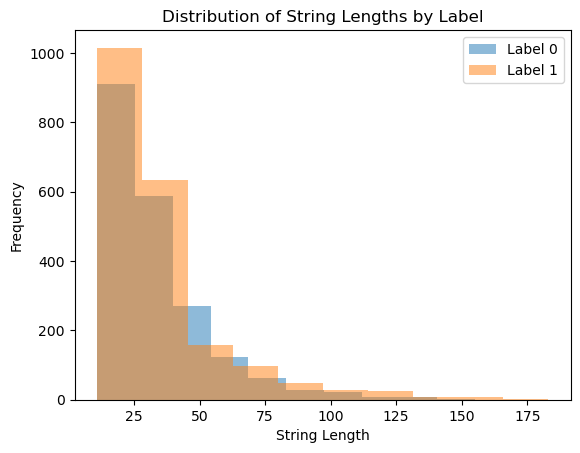

In [5]:
# Calculate string lengths for each label
df['Length'] = df['Sequence'].apply(len)

# Split the DataFrame by label
label_0_lengths = df[df['label'] == 0]['Length']
label_1_lengths = df[df['label'] == 1]['Length']

# Create histograms
plt.hist(label_0_lengths, alpha=0.5, label='Label 0', bins=10)
plt.hist(label_1_lengths, alpha=0.5, label='Label 1', bins=10)

plt.xlabel('String Length')
plt.ylabel('Frequency')
plt.title('Distribution of String Lengths by Label')
plt.legend()
plt.show()

In [6]:
# Group by label and calculate maximum and minimum lengths
grouped = df.groupby('label')['Length'].agg(['max', 'min'])
print(grouped)

       max  min
label          
0      155   11
1      183   11


# 2 Preprocess sequences
After, we will replace not common aminoacids. Furthermore, protein sequences are of different length. Depending of the method of WE you are using, you may need to use the same length for all sequences. 

In [7]:
def transform_seq(seq, max_len):
        seq1 = seq.replace('B', 'N')  # asparagine N / aspartic acid  D - asx - B
        seq2 = seq1.replace('Z', 'Q')  # glutamine Q / glutamic acid  E - glx - Z
        seq3 = seq2.replace('U',
                            'C')  # selenocisteina, the closest is the cisteine. but it is a different aminoacid . take care.
        seq4 = seq3.replace('O', 'K')  # Pyrrolysine to lysine
        seq = seq4.replace('X', '')  # unknown character eliminated
        if max_len:
            seq = seq[0:max_len]
        return seq


seqs = df['Sequence']
max_len = 200
seqs_new = list(map(lambda seq:transform_seq(seq, max_len),seqs))


# 3 load the WE model
Here we will use the Protvec model. This means that we will open the WordEmbedding class with a matrix file ( Protvec). The ngram len will be 3, used in Ptotvec and the vector dim is 100. 

protvec file can be obtained at https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/JMFHTN


In [8]:
from propythia.wordembedding.word_embedding import WordEmbedding as wv

protvec_file = '/home/martinha/propythia/propythia/src/propythia/wordembedding/protVec_100d_3grams.csv'

w2v = wv(emb_matrix_file=protvec_file,
         ngram_len=3 , sequence_max_len= max_len , vectordim=100)

2023-08-20 11:10:04.398807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


WordEmbedding is running..
--MATRIX LOADED--


# 4 get protein vectors representations
With the WE model loaded now we will transform the sequences into vectors. 
Three methods can be used: 

    • Method 1: Substitute directly the n-grams presented in the sequence by the WE vector. Being K the dimension of the word and N the dimension of the WE vector, a sequence of size L will be represented by a final vector of
    (L − k − 1) ∗ N elements. 
    This method preserves the spatial information of the location of biological words.
    
    • Method 2: k-mer word frequencies are calculated and multiplied by the corresponding WE vectors. A sequence,
    independent of the size, will be represented by a matrix of dimensions Number of words ∗ N.
    
    • Method 3: All the vectors of Method 2 are summed to reproduce a single vector of dimension N.
    
The method choosed will also impact the model choice. Deep learning architectures such as LSTM make more sense with method 1, where the sequence order is maintained. Method 3, for simplicity is suitable for ML models. 

# 4.1 Protein representations with method 3 for ML

Method3: Each sequence will be represented by a vector of 100 dimension. This will be indepedent of the differences in the sequence length. This method, does not maintain the spatial relationships between aminoacids. Also, the fact that generates low dimensional features are better suited for shallow machine learning. 

In [9]:
# Initialize an empty numpy array
num_sequences = len(seqs_new)  # Number of sequences
result_array = np.zeros((num_sequences, 100))

# Loop through the sequences and append vectors to the array
for idx, i in enumerate(seqs_new):
    vector = w2v.convert_seq2vec(method=3, sequence=i, padding = True)
    result_array[idx] = vector

print(result_array.shape)

(4042, 100)


splitting the data with sklearn train_test_split. We will define the X and y and create a test split with 0.33 size. 

In [10]:
from sklearn.model_selection import train_test_split

X = result_array
y = df['label']

df_x_train, df_x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print('train_x', df_x_train.shape)
print('test_x', df_x_test.shape)

train_x (2708, 100)
test_x (1334, 100)


Import and open Shallow ML propythia class.


We will keep the report name as None to avoid create unnecassary files

In [11]:
from propythia.ml.shallow_ml import ShallowML
from sklearn.metrics import make_scorer, matthews_corrcoef

# define ml class
# create Machine learning object

report = None
ml = ShallowML(x_train=df_x_train, x_test=df_x_test, y_train=y_train, y_test=y_test,
               report_name=report, columns_names= None)


'numpy.ndarray' object has no attribute 'columns'
no features names listed


/home/martinha/miniconda3/envs/propythia/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Lets try a RF model. In Propythia, and when using the train best model, a grid search parameter optimization will be run. If a  param grid is not given, a default one is used. 

In [12]:
ml = ShallowML(x_train=df_x_train, x_test=df_x_test, y_train=y_train, y_test=y_test,
               report_name=None, columns_names= None)

# TRAIN BEST MODEL
best_model = ml.train_best_model(model = 'rf', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=None,
                                     n_jobs=40, random_state=1, refit=True)

'numpy.ndarray' object has no attribute 'columns'
no features names listed
performing gridSearch...
GridSearchCV took 16.29 seconds for 6 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf',
                                        RandomForestClassifier(random_state=1))]),
             n_jobs=40,
             param_grid=[{'clf__bootstrap': [True], 'clf__criterion': ['gini'],
                          'clf__max_features': ['sqrt', 'log2'],
                          'clf__n_estimators': [10, 100, 500]}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.711 (std: 0.032)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'log2', 'clf__n_estimators': 500}
 

Model with rank: 2
 Mean validation score: 0.710 (std: 0.028)
 Parameters: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_features': 'sqrt', 'cl

In [13]:
scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       667
           1       0.88      0.82      0.85       667

    accuracy                           0.85      1334
   macro avg       0.85      0.85      0.85      1334
weighted avg       0.85      0.85      0.85      1334

[[589  78]
 [120 547]]
Accuracy: 0.8515742128935532
MCC: 0.7045465886849815
log_loss: 0.41786503814772324
f1 score: 0.846749226006192
roc_auc: 0.8515742128935532
Precision: [0.5    0.8752 1.    ]
Recall: [1.         0.82008996 0.        ]
fdr: 0.1248
sn: 0.8200899550224887
sp: 0.8830584707646177


lets try a SVC model with a defined paramgrid and a Logistic regression. 

In [14]:
# SVC
param_grid = {'clf__C': [0.1, 1.0, 10],
                        'clf__kernel': ['rbf', 'linear'],
                        'clf__gamma': [0.001,0.0001]}
# TRAIN BEST MODEL

# we will use as score the MCC
best_model = ml.train_best_model(model = 'svc', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=param_grid,
                                     n_jobs=40, random_state=1, n_iter=15, refit=True)

scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")


performing gridSearch...
GridSearchCV took 15.60 seconds for 12 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', SVC(random_state=1))]),
             n_jobs=40,
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'clf__gamma': [0.001, 0.0001],
                         'clf__kernel': ['rbf', 'linear']},
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.730 (std: 0.018)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

Model with rank: 2
 Mean validation score: 0.701 (std: 0.020)
 Parameters: {'clf__C': 1.0, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'}
 

Model with rank: 3
 Mean validation score: 0.672 (std: 0.023)
 Parameters: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'}
 

make_scorer(matthews_corrcoef)
5
Best score (scorer: make_scorer(matthews_corrcoef)) and parameters from a 5

In [15]:
# we will use as score the MCC
best_model = ml.train_best_model(model = 'knn', scaler=None,
                                     score=make_scorer(matthews_corrcoef),
                                     cv=5, optType='gridSearch',
                                     param_grid=None,
                                     n_jobs=40, random_state=1, n_iter=15, refit=True)

scores, report, cm, cm2 = ml.score_testset(classifier=best_model)
print(report)
print(cm)
for key, value in scores.items():
    print(f"{key}: {value}")

performing gridSearch...
GridSearchCV took 0.60 seconds for 24 candidate parameter settings.
GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', None),
                                       ('clf', KNeighborsClassifier())]),
             n_jobs=40,
             param_grid=[{'clf__leaf_size': [15, 30, 60],
                          'clf__n_neighbors': [2, 5, 10, 15],
                          'clf__weights': ['uniform', 'distance']}],
             scoring=make_scorer(matthews_corrcoef))
Model with rank: 1
 Mean validation score: 0.681 (std: 0.039)
 Parameters: {'clf__leaf_size': 15, 'clf__n_neighbors': 10, 'clf__weights': 'distance'}
 

Model with rank: 1
 Mean validation score: 0.681 (std: 0.039)
 Parameters: {'clf__leaf_size': 30, 'clf__n_neighbors': 10, 'clf__weights': 'distance'}
 

Model with rank: 1
 Mean validation score: 0.681 (std: 0.039)
 Parameters: {'clf__leaf_size': 60, 'clf__n_neighbors': 10, 'clf__weights': 'distance'}
 

make_scorer(matthews_corrcoef)
5
Be

Word embeddings can be retrieved as solo features. Therefore, using scikit learn (or any other library of interest) directly, instead of Propythia, is also possible. Lets see how a SVC model performs.

In [16]:
from sklearn import svm
clf = svm.SVC(C=10,gamma=0.001,kernel='rbf')
best_model = clf.fit(df_x_train, y_train)
y_pred = clf.predict(df_x_test)
score = matthews_corrcoef(y_test, y_pred)

print(score)


0.7286430523351184


# 4.2 Protein representations with method 1 for DL

In method 1, each sequence will be represented by a vector of N trigrams with 100 len, this is, N * 100 size. 
This vector can be then flat if necessary. 


In [17]:
# Initialize an empty numpy array
num_sequences = len(seqs_new)  # Number of sequences
result_array = np.zeros((num_sequences, 198, 100))

# Loop through the sequences and append vectors to the array
for idx, i in enumerate(seqs_new):
    vector = w2v.convert_seq2vec(method=1, sequence=i, padding = True)
    result_array[idx] = vector

print(result_array.shape)

(4042, 198, 100)


In [18]:
X = result_array
y = df['label']

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print('train_x', X_train.shape)
print('test_x', x_test.shape)

train_x (2708, 198, 100)
test_x (1334, 198, 100)


Define a DL model. 
Convolutional and RNN are good choices for this problem. 

Besides that, adding callbacks such as early stopping and modelCheckpoint may be very beneficial

We first will use the tensorfow library as example and then a DL model train with Propythia will be made


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Conv1D,Conv2D, Flatten, MaxPool1D,MaxPool2D, Dropout, Input,GRU
from tensorflow.keras.layers import Embedding, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


# Lets first try a CNN based model

In [20]:
model = Sequential([
    Input(shape=(198, 100)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPool1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2,callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

2023-08-20 11:10:47.049474: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-20 11:10:47.050005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-20 11:10:47.109235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-20 11:10:47.109383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-20 11:10:47.109442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

2023-08-20 11:10:48.083318: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-20 11:10:48.101996: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/100


2023-08-20 11:10:48.438782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-08-20 11:10:48.576664: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-08-20 11:10:49.240652: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2023-08-20 11:10:49.311154: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


34/34 [==============================] - 9s 144ms/step - loss: 0.6643 - accuracy: 0.5562 - val_loss: 0.4670 - val_accuracy: 0.7528
Epoch 2/100
34/34 [==============================] - 0s 5ms/step - loss: 0.4139 - accuracy: 0.8148 - val_loss: 0.3953 - val_accuracy: 0.8284
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 0.3129 - accuracy: 0.8804 - val_loss: 0.3714 - val_accuracy: 0.8524
Epoch 4/100
34/34 [==============================] - 0s 4ms/step - loss: 0.2299 - accuracy: 0.9163 - val_loss: 0.4215 - val_accuracy: 0.8487
Epoch 5/100
34/34 [==============================] - 0s 4ms/step - loss: 0.1510 - accuracy: 0.9504 - val_loss: 0.4424 - val_accuracy: 0.8579
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9790 - val_loss: 0.4795 - val_accuracy: 0.8542
Epoch 7/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0594 - accuracy: 0.9861 - val_loss: 0.6097 - val_accuracy: 0.8450
Epoch 8/100
34/34 [====

In [21]:
# Test Loss: 1.6535
# Test Accuracy: 0.8508
# DR 0.5

# Print training and validation accuracy and loss
# print("Training Accuracy:", history.history['accuracy'])
# print("Validation Accuracy:", history.history['val_accuracy'])
# print("Training Loss:", history.history['loss'])
# print("Validation Loss:", history.history['val_loss'])

print('===================================')
print("Mean Training Accuracy:", np.mean(history.history['accuracy']))
print("Mean Validation Accuracy:", np.mean(history.history['val_accuracy']))
print("Mean Training Loss:", np.mean(history.history['loss']))
print("Mean Validation Loss:", np.mean(history.history['val_loss']))

print('===================================')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Mean Training Accuracy: 0.9615400018899337
Mean Validation Accuracy: 0.8464623793311741
Mean Training Loss: 0.0900860324669022
Mean Validation Loss: 0.7195863114750903
Test Loss: 0.4091
Test Accuracy: 0.8448


# a RNN - GRU based model

In [22]:
model = Sequential([
    Input(shape=(198, 100)),
    GRU(units=512, return_sequences=True),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=64,epochs = 100,validation_split=0.2, callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/100
34/34 [==============================] - 2s 32ms/step - loss: 0.7149 - accuracy: 0.5225 - val_loss: 0.6863 - val_accuracy: 0.5233
Epoch 2/100
34/34 [==============================] - 1s 26ms/step - loss: 0.6841 - accuracy: 0.5345 - val_loss: 0.6773 - val_accuracy: 0.5379
Epoch 3/100
34/34 [==============================] - 1s 26ms/step - loss: 0.6738 - accuracy: 0.5670 - val_loss: 0.6765 - val_accuracy: 0.5471
Epoch 4/100
34/34 [==============================] - 1s 26ms/step - loss: 0.6745 - accuracy: 0.5504 - val_loss: 0.6638 - val_accuracy: 0.5507
Epoch 5/100
34/34 [==============================] - 1s 30ms/step - loss: 0.8227 - accuracy: 0.5550 - val_loss: 0.6856 - val_accuracy: 0.5101
Epoch 6/100
34/34 [==============================] - 1s 28ms/step - loss: 0.6825 - accuracy: 0.5232 - val_loss: 0.6792 - val_accuracy: 0.5404
Epoch 7/100
34/34 [==============================] - 1s 28ms/step - loss: 0.6752 - accuracy: 0.5353 - val_loss: 0.6725 - val_accuracy: 0.5416
Epoch 

In [23]:
# Print training and validation accuracy and loss
# print("Training Accuracy:", history.history['accuracy'])
# print("Validation Accuracy:", history.history['val_accuracy'])
# print("Training Loss:", history.history['loss'])
# print("Validation Loss:", history.history['val_loss'])

print('===================================')
print("Mean Training Accuracy:", np.mean(history.history['accuracy']))
print("Mean Validation Accuracy:", np.mean(history.history['val_accuracy']))
print("Mean Training Loss:", np.mean(history.history['loss']))
print("Mean Validation Loss:", np.mean(history.history['val_loss']))

print('===================================')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Mean Training Accuracy: 0.7550637490219541
Mean Validation Accuracy: 0.7255374601593724
Mean Training Loss: 0.44529645752023767
Mean Validation Loss: 0.5211031492109652
Test Loss: 0.3607
Test Accuracy: 0.8506


# network with CONV and LSTM layers

In [24]:
# Define the model
model = Sequential([
    Input(shape=(198, 100)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPool1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPool1D(pool_size=2),
    LSTM(units=128, return_sequences=True),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test, y_test)

Epoch 1/100
17/17 [==============================] - 8s 228ms/step - loss: 0.6806 - accuracy: 0.5401 - val_loss: 0.6280 - val_accuracy: 0.6089
Epoch 2/100
17/17 [==============================] - 0s 11ms/step - loss: 0.5929 - accuracy: 0.6535 - val_loss: 0.5056 - val_accuracy: 0.7445
Epoch 3/100
17/17 [==============================] - 0s 11ms/step - loss: 0.4861 - accuracy: 0.7658 - val_loss: 0.4394 - val_accuracy: 0.8084
Epoch 4/100
17/17 [==============================] - 0s 11ms/step - loss: 0.4135 - accuracy: 0.8267 - val_loss: 0.3977 - val_accuracy: 0.8432
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 0.3540 - accuracy: 0.8557 - val_loss: 0.3730 - val_accuracy: 0.8511
Epoch 6/100
17/17 [==============================] - 0s 11ms/step - loss: 0.3179 - accuracy: 0.8817 - val_loss: 0.4850 - val_accuracy: 0.8255
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 0.3202 - accuracy: 0.8822 - val_loss: 0.4777 - val_accuracy: 0.8418
Epoch

In [25]:
# Print training and validation accuracy and loss
# print("Training Accuracy:", history.history['accuracy'])
# print("Validation Accuracy:", history.history['val_accuracy'])
# print("Training Loss:", history.history['loss'])
# print("Validation Loss:", history.history['val_loss'])

print('===================================')
print("Mean Training Accuracy:", np.mean(history.history['accuracy']))
print("Mean Validation Accuracy:", np.mean(history.history['val_accuracy']))
print("Mean Training Loss:", np.mean(history.history['loss']))
print("Mean Validation Loss:", np.mean(history.history['val_loss']))

print('===================================')

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Mean Training Accuracy: 0.9085580062866211
Mean Validation Accuracy: 0.8291436171531678
Mean Training Loss: 0.23052928060293199
Mean Validation Loss: 0.533099365234375
Test Loss: 0.4218
Test Accuracy: 0.8275


All the netwroks achieved good result. These models can also be optimized to search for a better combination of parameters

# We can also do the DL using propythia functions if wanted. 
All the models performed similary. We wil use the GRU network as an example of the use with ProPythia
Lets also try to increase the number of epochs

In [37]:
from propythia.ml.deep_ml import DeepML
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

def model_gru():
    model = Sequential([
        Input(shape=(198, 100)),
        GRU(units=16, return_sequences=True),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model 


dl=DeepML(X_train, y_train, x_test, y_test, number_classes=2, problem_type='binary',
          x_dval=None, y_dval=None, epochs=100, batch_size=64,
          path='', report_name=None, verbose=1,
         early_stopping_patience=30, reduce_lr_patience=20, reduce_lr_factor=0.2, reduce_lr_min=0.00001,
                 )

model = KerasClassifier(build_fn=model_gru)

# run the model in Propythia
history = dl.run_model(model)

Epoch 1/100
39/39 [==============================] - 1s 19ms/step - loss: 0.6680 - accuracy: 0.5717 - val_loss: 0.5707 - val_accuracy: 0.7306

Epoch 00001: val_loss improved from inf to 0.57067, saving model to weights.hdf5
Epoch 2/100
39/39 [==============================] - 1s 15ms/step - loss: 0.5464 - accuracy: 0.7447 - val_loss: 0.4683 - val_accuracy: 0.8007

Epoch 00002: val_loss improved from 0.57067 to 0.46835, saving model to weights.hdf5
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 0.4555 - accuracy: 0.8153 - val_loss: 0.3912 - val_accuracy: 0.8266

Epoch 00003: val_loss improved from 0.46835 to 0.39117, saving model to weights.hdf5
Epoch 4/100
39/39 [==============================] - 1s 15ms/step - loss: 0.3915 - accuracy: 0.8249 - val_loss: 0.3709 - val_accuracy: 0.8561

Epoch 00004: val_loss improved from 0.39117 to 0.37095, saving model to weights.hdf5
Epoch 5/100
39/39 [==============================] - 1s 13ms/step - loss: 0.3458 - accuracy:

<Figure size 640x480 with 0 Axes>

In [38]:
# evaluate on propythia
scores, report, cm, cm2 = dl.score_testset_classification()
scores

{'Accuracy': 0.8710644677661169,
 'MCC': 0.7422123556738972,
 'log_loss': 0.4256619883165948,
 'f1 score': 0.8700906344410877,
 'roc_auc': 0.8710644677661169,
 'Precision': array([0.5       , 0.87671233, 1.        ]),
 'Recall': array([1.        , 0.86356822, 0.        ]),
 'fdr': 0.1232876712328767,
 'sn': 0.863568215892054,
 'sp': 0.8785607196401799}

We can see that even reducing the model architecture, the model is overfitting. One can now try and try to optimize these models in order to improve the accuracy and reduce the loss. other WE models and other vector representations may also be tested. for example, try to train a digram WE model. Other aspects may be try other protein representations such as physicochemical features or one hot encodings.